### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

# for hierarchical clusterization
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import  pdist
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime
import os
sns.set()

In [4]:
!unzip raai_school_2024.zip

Archive:  raai_school_2024.zip
  inflating: raai_school_2024.csv    
  inflating: Задание ЛШ 2024.docx  


## Loading data

(already with anomalies)

In [2]:
data = pd.read_csv("raai_school_2024.csv", sep = ";")
data["payment_period"] = pd.to_datetime(data["payment_period"])
anomaly_column = pd.read_csv("anomaly_column.csv", sep = ";")
data["is_anomaly"] = anomaly_column["is_anomaly"].fillna(1.)
data['user_id'] = data['house_tkn'].astype(str) + '_' + data['flat_tkn'].astype(str)

## Preprocessing
- удаление двух месяцев у которых мало записей
- one-hot encoding месяцев
- выделение конкретных **домов** с аномально маленькими/большими значениями по каждому из столбцов
- EIF, возможно другие методы если он окажется неадекватным

-> Результатом является data_filtered

### Artificial cutoff of the anomaly values
- for each volume take a percentile, but do not exclude NaN or 0

In [3]:
def clip_by_percentile(data, percentile = 0.95):
    numeric_features = ['income', 'debt', 'raised',
           'volume_cold', 'volume_hot', 'volume_electr']

    for feature in numeric_features:
        threshold = data[feature].quantile(percentile)
        data_filtered[feature] = data[feature].clip(upper=threshold)

    for feature in ['income', 'debt', 'raised']:
        threshold = data[feature].quantile(1-percentile)
        data_filtered[feature] = data[feature].clip(lower=min(0, threshold))

    return data

### Filling NaN values
1. Нахождение людей у которых просто нет горячей воды, заполнение таких значениями -1.
2. Отрицательные значения volume временно заполняем 0
3. Всех остальных имеет смысл заполнть медианой так как мы работаем на уровне записей

#### Filling hot water

In [4]:
# Issue is - we have various cases for hot water. It might be planned turnoff, it might be just a missed value
# it might be that user doesn't have hot water (and therefore doesn't pay).
def fill_nan_hot_water(
    data, # the table that has the nan values
    fill_value_seasonal_turnoff = 0, # value to fill users who had a planned turnoff
    fill_value_no_hot = 0, # value to fill the users who have no hot water with, naturally 0
    fill_value_forgetful_users = 0, # value to fill users who just forgot to send hot water
    add_column_seasonal = True, # whether to add column that there was a planned turnoff
    add_column_no_hot = True,
    add_columns_is_na = False
):
    data["volume_hot_na"] = data["volume_hot"].isna()

    # Filling all those who have planned turned off water
    months = data['payment_period'].map(lambda dt: dt.month)
    is_summer_month = (months == 5) | (months == 6) | (months == 7)
    del months

    houses_with_hot_water = data.groupby("house_tkn")["volume_hot_na"].agg(lambda x: not x.any())
    houses_with_no_hot_water_in_summer = data[is_summer_month].groupby("house_tkn")["volume_hot_na"].agg(lambda x: x.all())
    houses_with_seasonal_hot_water = houses_with_hot_water[houses_with_hot_water].index.intersection(
        houses_with_no_hot_water_in_summer[houses_with_no_hot_water_in_summer].index
    )
    del houses_with_hot_water
    del houses_with_no_hot_water_in_summer

    data_with_planned_turnoff = data[data["house_tkn"].isin(houses_with_seasonal_hot_water[houses_with_seasonal_hot_water])]
    data_with_planned_turnoff.loc[:, "volume_hot"].fillna(fill_value_seasonal_turnoff, inplace = True)

    data_updated = pd.concat([data_with_planned_turnoff, data[~data["house_tkn"].isin(data_with_planned_turnoff["house_tkn"])]])

    if add_column_seasonal:
        data_updated["seasonal_turnoff"] = False
        data_updated.loc[data_updated["house_tkn"].isin(data_with_planned_turnoff["house_tkn"]), "seasonal_turnoff"] = True
    del data_with_planned_turnoff
    del houses_with_seasonal_hot_water

    # Filling all those who have no hot water
    user_ids_who_have_no_hot = data_updated.groupby("user_id")["volume_hot_na"].agg(lambda x: x.all())
    users_with_no_hot = data_updated[data_updated["user_id"].isin(user_ids_who_have_no_hot[user_ids_who_have_no_hot].index)]
    users_with_no_hot["volume_hot"] = users_with_no_hot["volume_hot"].fillna(fill_value_no_hot)

    data_updated = pd.concat([users_with_no_hot, data_updated[~data["user_id"].isin(users_with_no_hot["user_id"])]])

    if add_column_no_hot:
        data_updated["no_hot_water"] = False
        data_updated.loc[data_updated["user_id"].isin(users_with_no_hot["user_id"]), "no_hot_water"] = True
    del users_with_no_hot

    # Filling the rest
    if add_columns_is_na:
        data_updated["missed_hot_water"] = data_updated["volume_hot"].isna()
    data_updated["volume_hot"] = data_updated["volume_hot"].fillna(fill_value_forgetful_users)

    data_updated.drop(columns = ["volume_hot_na"], inplace = True)
    return data_updated

In [5]:
# seasonal_turnoff    1614807
# no_hot_water        1637665
# forgot_hot_water       1150

#### Clipping volumes to be >=0 (except hot water)

In [6]:
def clip_volumes(data):
    # Filling negative values with 0 (hot water as I previouslt overlooked didn't have any so we don't wanna clear previous result)
    data["volume_cold"] = data["volume_cold"].clip(lower=0)
    data["volume_electr"] = data["volume_electr"].clip(lower=0)
    return data

### Filling the rest NaN with median & scale

In [7]:
def fill_na_with_median(data):
    # Fill all the left NaNs with median
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    return imputer.fit_transform(data)

def scale_values(data):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    return scaler.fit_transform(data)

## Correlation

In [ ]:
plt.figure(figsize=(10, 6))
number_features = ['income', 'debt', 'raised','volume_cold', 'volume_hot', 'volume_electr']
data_with_real_numeric = data[number_features].dropna()
data_with_real_numeric = (data_with_real_numeric-data_with_real_numeric.mean())/data_with_real_numeric.std()
pearson = data_with_real_numeric.corr(method = 'pearson')
sns.heatmap(pearson, annot = True, fmt = ".3f")
plt.title('Pearson correlation of numerical data')

In [ ]:
plt.figure(figsize=(10, 6))
number_features = ['income', 'debt', 'raised','volume_cold', 'volume_hot', 'volume_electr']
data_with_real_numeric = data[number_features].dropna()
data_with_real_numeric = (data_with_real_numeric-data_with_real_numeric.mean())/data_with_real_numeric.std()
spearman = data_with_real_numeric.corr(method = 'spearman')
sns.heatmap(spearman, annot = True, fmt = ".3f")
plt.title('Spearman correlation of numerical data')

# Кластеризация данных

- если делать деревом решений то не должно возникать проблемы с NaN значениями
- если делать стандартными методам сначала надо нормализовать и разделить данные на NaN и все остальные, либо выделять тех у кого только холодная вода с целью заставить им эту воду 0, а остальных кокнуть как аномалии вручную. Некоторые стандартные методы: K-Means, DBSCAN

**До начала кластеризации** надо убрать дома и квартиры объединив их в $user\_id$. Дальше надо подумать о том каие признаки можно дабвить в табличку (например максимум, минимум, среднее, отклонение, частота выплат). Также можно пытаться учесть отдельно
1. летний период отключения горячей воды
2. отсутствие горячей воды в доме
3. периоды повышенного потребления воды, например столбца по типу +1 за зимний месяц, -1 за летний или вообще булевые (для K-means очевидно плохая идея)
4. максимальная и минимальная разница между следующим и предыдущим месяцем (имеет смысл по холодной воде чтобы исзбежать разборок с летним отключением воды)
5. среднее, стандартное отклонение ненулевых значений
6. стоимость показателей, при кластеризации имеет смысл более значимо рассматривать **raised**, **income**, **debt**. Учитывая их динамическое изменение имеет смысл их слегка модифицировать для избежания сильной корреляции

In [8]:
%%time
data["month_of_admission"] = data['payment_period'].map(lambda dt: dt.month)
data_filtered = data[(data["month_of_admission"] != 10) & (data["month_of_admission"] != 12)]
data_filtered = clip_by_percentile(data_filtered)

data_filtered = fill_nan_hot_water(data,
    fill_value_seasonal_turnoff = 0,
    fill_value_no_hot = 0,
    fill_value_forgetful_users = data_filtered["volume_hot"].median(),
    add_column_seasonal = False,
    add_column_no_hot = False,
    add_columns_is_na = False
)

data_filtered = clip_volumes(data_filtered)

columns_with_na = ['volume_cold', 'volume_electr']
data_filtered.loc[:, columns_with_na] = fill_na_with_median(data_filtered[columns_with_na])
data_filtered = data_filtered[data_filtered["is_anomaly"] == 0]

<ipython-input-3-c7a169209a58>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered[feature] = data[feature].clip(upper=threshold)
<ipython-input-3-c7a169209a58>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered[feature] = data[feature].clip(upper=threshold)
<ipython-input-3-c7a169209a58>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

CPU times: user 59.3 s, sys: 1.86 s, total: 1min 1s
Wall time: 1min 5s


### K-Means on aggregated partly data

In [17]:
# encode month of admission to be numbers in order (without skips):
months = data_filtered.month_of_admission.unique()
months.sort()

replace_ = {"month_of_admission" : {
    month : i for month, i in zip(months, range(len(months)))
}}
data_filtered = data_filtered.replace(replace_)
data_filtered.head()

,house_tkn,flat_tkn,payment_period,income,debt,raised,volume_cold,volume_hot,volume_electr,is_anomaly,user_id,month_of_admission
235,2,24327,2023-01-01,68.13,0.00,26.37,2.36,0.0,123.0,0.0,2_24327,0
656,2,147760,2023-01-01,0.00,2578.36,1759.71,5.00,0.0,123.0,0.0,2_147760,0
781,2,208599,2023-01-01,0.00,1253.49,0.00,5.00,0.0,123.0,0.0,2_208599,0
782,2,208599,2023-03-01,0.00,1253.49,0.00,5.00,0.0,123.0,0.0,2_208599,2
783,2,208599,2023-04-01,0.00,1253.49,0.00,5.00,0.0,123.0,0.0,2_208599,3


In [33]:
grouped = data_filtered.groupby('user_id')
user_features = grouped.agg({
    'income': ['min', 'max', 'mean', 'std'],
    'debt': ['min', 'max', 'mean', 'std'],
    'raised': ['min', 'max','mean', 'std'],
    'volume_cold': ['min', 'max','mean', 'std'],
    'volume_hot': ['min', 'max','mean', 'std'],
    'volume_electr': ['min', 'max','mean', 'std'],
    'month_of_admission': ['min', 'max', 'nunique'],
})

user_features.columns = ['_'.join(col) for col in user_features.columns]

user_features['payment_delay'] = (user_features['month_of_admission_max'] - user_features['month_of_admission_min'])
user_features['payment_delay'] /= user_features['month_of_admission_nunique']  # Average delay per month

In [32]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import random

random.seed(42)  # Set a fixed seed for reproducibility

def make_k_means_on_subset(columns_to_consider, subset_size=1000):
    global user_features
    user_features_to_consider = user_features[columns_to_consider].fillna(0)
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(user_features_to_consider)

    random_indexes = random.sample(range(len(scaled_features)), subset_size)
    subset_features = scaled_features[random_indexes]
    n_clusters = 8

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(subset_features)

    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    return subset_features, labels, cluster_centers

In [23]:
def plot_2d_kmeans_results(columns_to_consider, columns_to_plot, subset_features, labels, cluster_centers):
    plot_combinations = [columns_to_consider.index(col) for col in columns_to_plot]
    fig, axes = plt.subplots(len(plot_combinations), len(plot_combinations), figsize=(12, 12))
    n_clusters = labels.max() + 1

    for i in range(len(plot_combinations)):
        for j in range(len(plot_combinations)):
            ax = axes[i, j]
            x_id = plot_combinations[i]
            y_id = plot_combinations[j]

            for j in range(n_clusters):
                cluster_points = subset_features[labels == j]
                ax.scatter(cluster_points[:, x_id], cluster_points[:, y_id], label=f'{j}', s=10)

            ax.scatter(cluster_centers[:, x_id], cluster_centers[:, y_id], marker='*', s=100, c='black', label='Cluster Centers')

            ax.set_xlabel(columns_to_consider[x_id])
            ax.set_ylabel(columns_to_consider[y_id])

            ax.set_title(f'Clusters: {columns_to_consider[x_id]}, {columns_to_consider[y_id]}')
            ax.legend()

    plt.tight_layout()

    plt.show()

In [30]:
from mpl_toolkits.mplot3d import Axes3D
def plot_3d_kmeans_results(columns_to_consider, columns_to_plot, subset_features, labels, cluster_centers):
    plot_combinations = [columns_to_consider.index(col) for col in columns_to_plot]
    n_clusters = labels.max() + 1

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i in range(n_clusters):
        cluster_points = subset_features[labels == i]
        ax.scatter(cluster_points[:, plot_combinations[0]],
                   cluster_points[:, plot_combinations[1]],
                   cluster_points[:, plot_combinations[2]], label=f'Cluster {i}')

    ax.scatter(cluster_centers[:, plot_combinations[0]],
               cluster_centers[:, plot_combinations[1]],
               cluster_centers[:, plot_combinations[2]], marker='*', s=200, c='black', label='Cluster Centers')

    ax.set_xlabel(columns_to_consider[plot_combinations[0]])
    ax.set_ylabel(columns_to_consider[plot_combinations[1]])
    ax.set_zlabel(columns_to_consider[plot_combinations[2]])

    ax.legend()
    plt.show()

In [44]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
%matplotlib nbagg

def plot_3d_kmeans_results_rotating(columns_to_consider, columns_to_plot, subset_features, labels, cluster_centers, plot_vertices_number=1000):
    plot_combinations = [columns_to_consider.index(col) for col in columns_to_plot]
    n_clusters = labels.max() + 1

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    scatters = []
    for i in range(n_clusters):
        scatters.append(ax.scatter([], [], [], label=f'Cluster {i}'))
    center_scatter = ax.scatter([], [], [], marker='*', s=200, c='black', label='Cluster Centers')

    ax.set_xlabel(columns_to_consider[plot_combinations[0]])
    ax.set_ylabel(columns_to_consider[plot_combinations[1]])
    ax.set_zlabel(columns_to_consider[plot_combinations[2]])
    ax.legend()

    plot_subset_features = []
    for j in range(n_clusters):
        cluster_indices = np.where(labels == j)[0]
        plot_subset_features.extend(random.sample(list(cluster_indices), 20))
    plot_subset_features.extend(random.sample(subset_features, plot_vertices_number - 20*n_clusters))
    plot_subset_features = np.array(plot_subset_features)

    def animate(i):
        #ax.cla()
        for j in range(n_clusters):
            cluster_points = plot_subset_features[labels == j]
            scatters[j]._offsets3d = (cluster_points[:, plot_combinations[0]],
                                     cluster_points[:, plot_combinations[1]],
                                     cluster_points[:, plot_combinations[2]])

        center_scatter._offsets3d = (cluster_centers[:, plot_combinations[0]],
                                    cluster_centers[:, plot_combinations[1]],
                                    cluster_centers[:, plot_combinations[2]])

        ax.view_init(30, i)  # Adjust view angles as needed
        return scatters + [center_scatter]

    ani = FuncAnimation(fig, animate, frames=360, interval=20, blit=True)
    ani.save('simulation.mp4', dpi=150, fps=30, writer='ffmpeg', extra_args=['-vcodec', 'libx264'])

    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


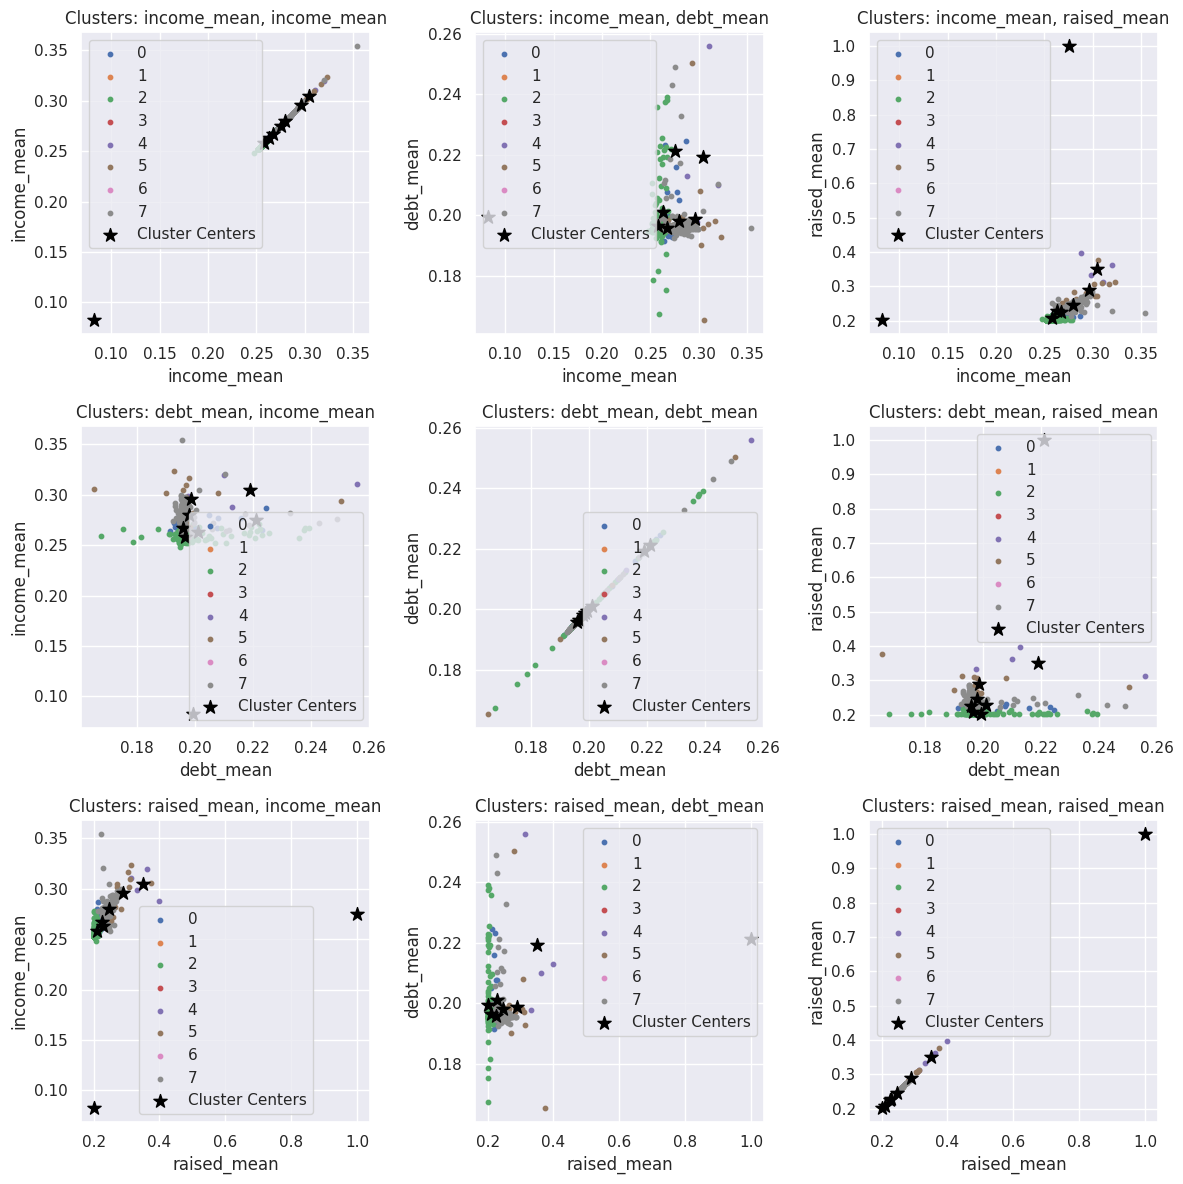

In [29]:
columns_to_consider = ["income_min", "income_max", "income_mean", "income_std",
                       "debt_min", "debt_max", "debt_mean", "debt_std",
                       "raised_min", "raised_max", "raised_mean", "raised_std"]
subset_features, labels, cluster_centers = make_k_means_on_subset(columns_to_consider)

columns_to_plot = ["income_mean", "debt_mean", "raised_mean"]
plot_2d_kmeans_results(columns_to_consider, columns_to_plot, subset_features, labels, cluster_centers)

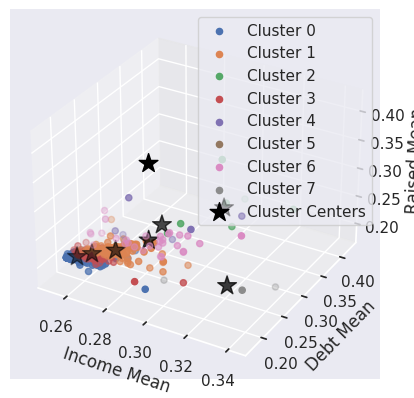

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


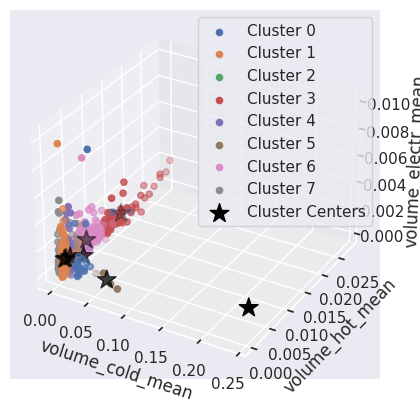

In [34]:
columns_to_consider = ["volume_cold_mean",
                       "volume_hot_mean",
                       "volume_electr_mean"]

subset_features, labels, cluster_centers = make_k_means_on_subset(columns_to_consider)

columns_to_plot = ["volume_cold_mean",
                       "volume_hot_mean",
                       "volume_electr_mean"]
plot_3d_kmeans_results(columns_to_consider, columns_to_plot, subset_features, labels, cluster_centers)

In [46]:
columns_to_consider = ["volume_cold_max", "volume_cold_mean",
                       "volume_hot_max", "volume_hot_mean",
                       "volume_electr_max", "volume_electr_mean"]

subset_features, labels, cluster_centers = make_k_means_on_subset(columns_to_consider)

columns_to_plot = ["volume_cold_mean",
                       "volume_hot_mean",
                       "volume_electr_mean"]
plot_3d_kmeans_results(columns_to_consider, columns_to_plot, subset_features, labels, cluster_centers)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<IPython.core.display.Javascript object>

In [43]:
plot_3d_kmeans_results_rotating(columns_to_consider, columns_to_plot, subset_features, labels, cluster_centers)

<IPython.core.display.Javascript object>

D:\E\Downloads\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


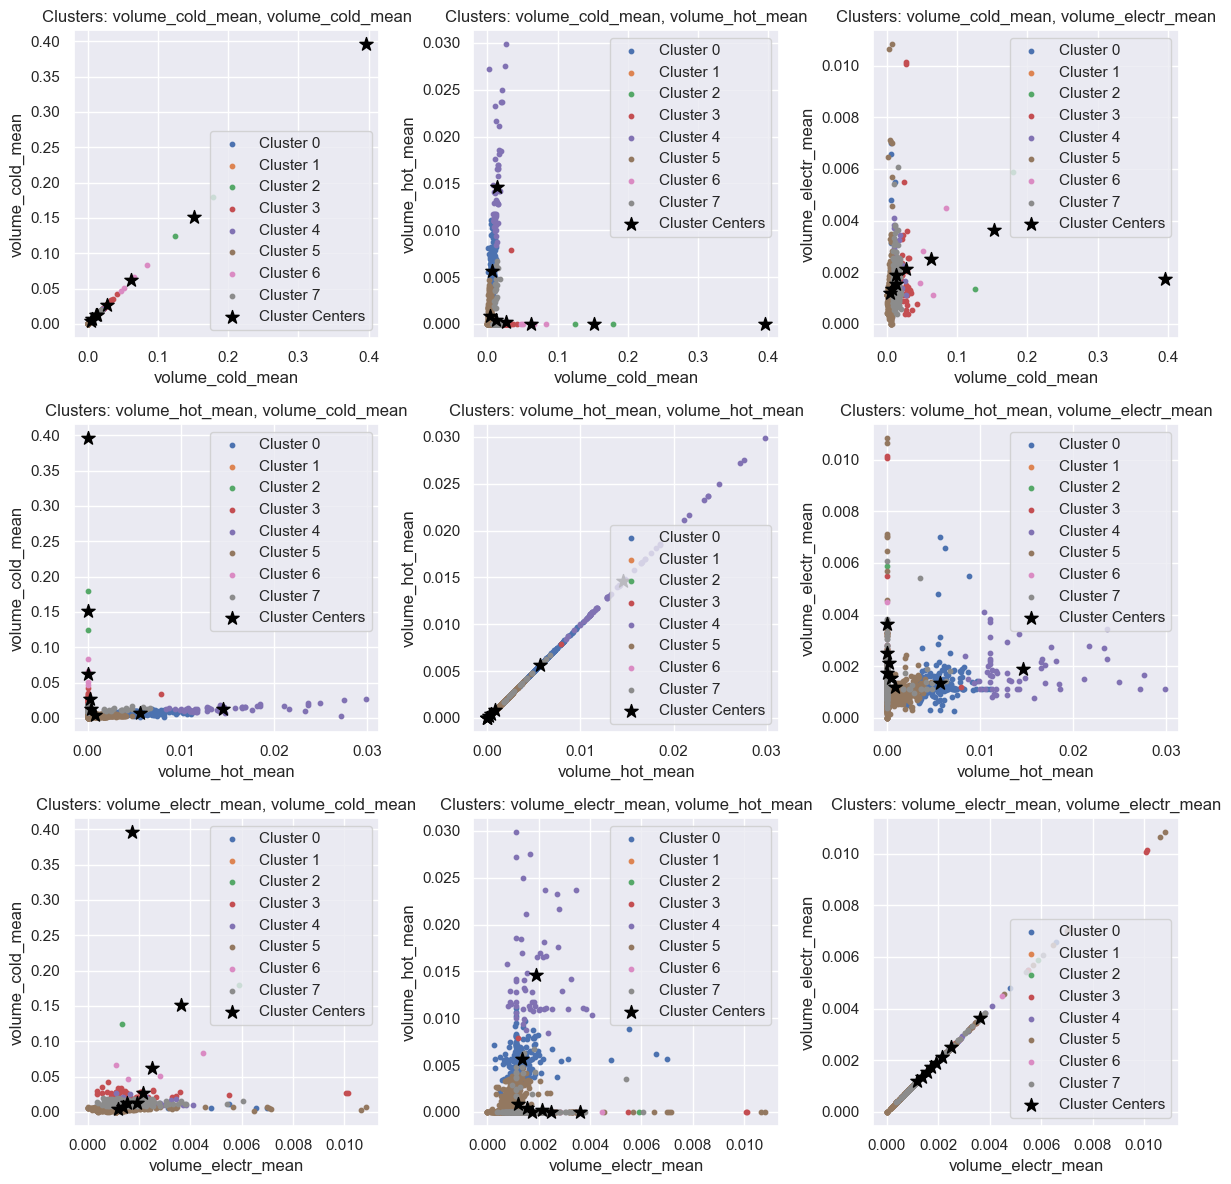

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

columns_to_consider = ["volume_cold_mean",
                       "volume_hot_mean",
                       "volume_electr_mean",]

user_features = user_features[columns_to_consider].fillna(0)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(user_features)

subset_features = scaled_features[:1000]
n_clusters = 8

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(subset_features)

labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

plot_combinations = [
   0, 1, 2
]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in range(len(plot_combinations)):
    for j in range(len(plot_combinations)):
        ax = axes[i, j]  # Position in the grid
        x_id = plot_combinations[i]
        y_id = plot_combinations[j]

        # Plot clusters for each combination
        for j in range(n_clusters):  # Adjust for the number of clusters
            cluster_points = subset_features[labels == j]
            ax.scatter(cluster_points[:, x_id], cluster_points[:, y_id], label=f'Cluster {j}', s=10)

        ax.scatter(cluster_centers[:, x_id], cluster_centers[:, y_id], marker='*', s=100, c='black', label='Cluster Centers')

        ax.set_xlabel(columns_to_consider[x_id])
        ax.set_ylabel(columns_to_consider[y_id])

        ax.set_title(f'Clusters: {columns_to_consider[x_id]}, {columns_to_consider[y_id]}')
        ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

plt.show()

## Hieararchical clustering

### Run first

In [9]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
import time as time
import random

random.seed(42)

grouped = data_filtered.groupby('user_id')
user_features = grouped.agg({
    'income': ['min', 'max', 'mean', 'std'],
    'debt': ['min', 'max', 'mean', 'std'],
    'raised': ['min', 'max','mean', 'std'],
    'volume_cold': ['min', 'max','mean', 'std'],
    'volume_hot': ['min', 'max','mean', 'std'],
    'volume_electr': ['min', 'max','mean', 'std'],
    'month_of_admission': ['min', 'max', 'nunique'],
})

user_features.columns = ['_'.join(col) for col in user_features.columns]

user_features['payment_delay'] = (user_features['month_of_admission_max'] - user_features['month_of_admission_min'])
user_features['payment_delay'] /= user_features['month_of_admission_nunique']  # Average delay per month

In [42]:
def plot_2d_results(columns_to_consider, columns_to_plot, subset_features, labels, plot_vertices_number=1000):
    plot_combinations = [columns_to_consider.index(col) for col in columns_to_plot]
    fig, axes = plt.subplots(len(plot_combinations), len(plot_combinations), figsize=(12, 12))
    n_clusters = labels.max() + 1

    plot_subset_indices = []
    for j in range(n_clusters):
        cluster_indices = np.where(labels == j)[0]
        plot_subset_indices.extend(random.sample(list(cluster_indices), min(len(cluster_indices), 20)))
    plot_subset_indices.extend(random.sample(range(len(subset_features)), min(len(subset_features), plot_vertices_number - 20*n_clusters)))
    subset_features = subset_features[plot_subset_indices]
    labels = labels[plot_subset_indices]

    for i in range(len(plot_combinations)):
        for j in range(len(plot_combinations)):
            ax = axes[i, j]
            x_id = plot_combinations[i]
            y_id = plot_combinations[j]

            for j in range(n_clusters):
                cluster_points = subset_features[labels == j]
                ax.scatter(cluster_points[:, x_id], cluster_points[:, y_id], label=f'{j}', s=10)

            ax.set_xlabel(columns_to_consider[x_id])
            ax.set_ylabel(columns_to_consider[y_id])

            ax.set_title(f'Clusters: {columns_to_consider[x_id]}, {columns_to_consider[y_id]}')
            ax.legend()

    plt.tight_layout()

    plt.show()

In [46]:
def plot_3d_results(columns_to_consider, columns_to_plot, subset_features, labels, plot_vertices_number=1000):
    plot_subset_indices = []
    n_clusters = labels.max() + 1
    for j in range(n_clusters):
        cluster_indices = np.where(labels == j)[0]
        plot_subset_indices.extend(random.sample(list(cluster_indices), min(len(cluster_indices), 20)))
    plot_subset_indices.extend(random.sample(range(len(subset_features)), min(len(subset_features), plot_vertices_number - 20*n_clusters)))
    subset_features = subset_features[plot_subset_indices]
    labels = labels[plot_subset_indices]

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, projection="3d", elev=7, azim=-80)
    ax1.set_position([0, 0, 0.95, 1])
    for l in np.unique(labels):
        ax1.scatter(
            subset_features[labels == l, 0],
            subset_features[labels == l, 1],
            subset_features[labels == l, 2],
            color=plt.cm.jet(float(l) / np.max(labels + 1)),
            s=20,
            edgecolor="k",
        )
    _ = fig1.suptitle(f"Without connectivity constraints (time {elapsed_time:.2f}s)")
    plt.show()

In [50]:
def run_ward(columns_to_consider, n_clusters=8, subset_size = 10000):
    global user_features
    X = user_features[columns_to_consider]
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    random_indexes = random.sample(range(len(X)), subset_size)
    X = X[random_indexes]

    print("Compute unstructured hierarchical clustering...")
    st = time.time()
    ward = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward").fit(X)
    elapsed_time = time.time() - st
    label = ward.labels_
    print(f"Elapsed time: {elapsed_time:.2f}s")
    print(f"Number of points: {label.size}")
    return X, label, scaler

### Experiments

Compute unstructured hierarchical clustering...
Elapsed time: 11.42s
Number of points: 10000


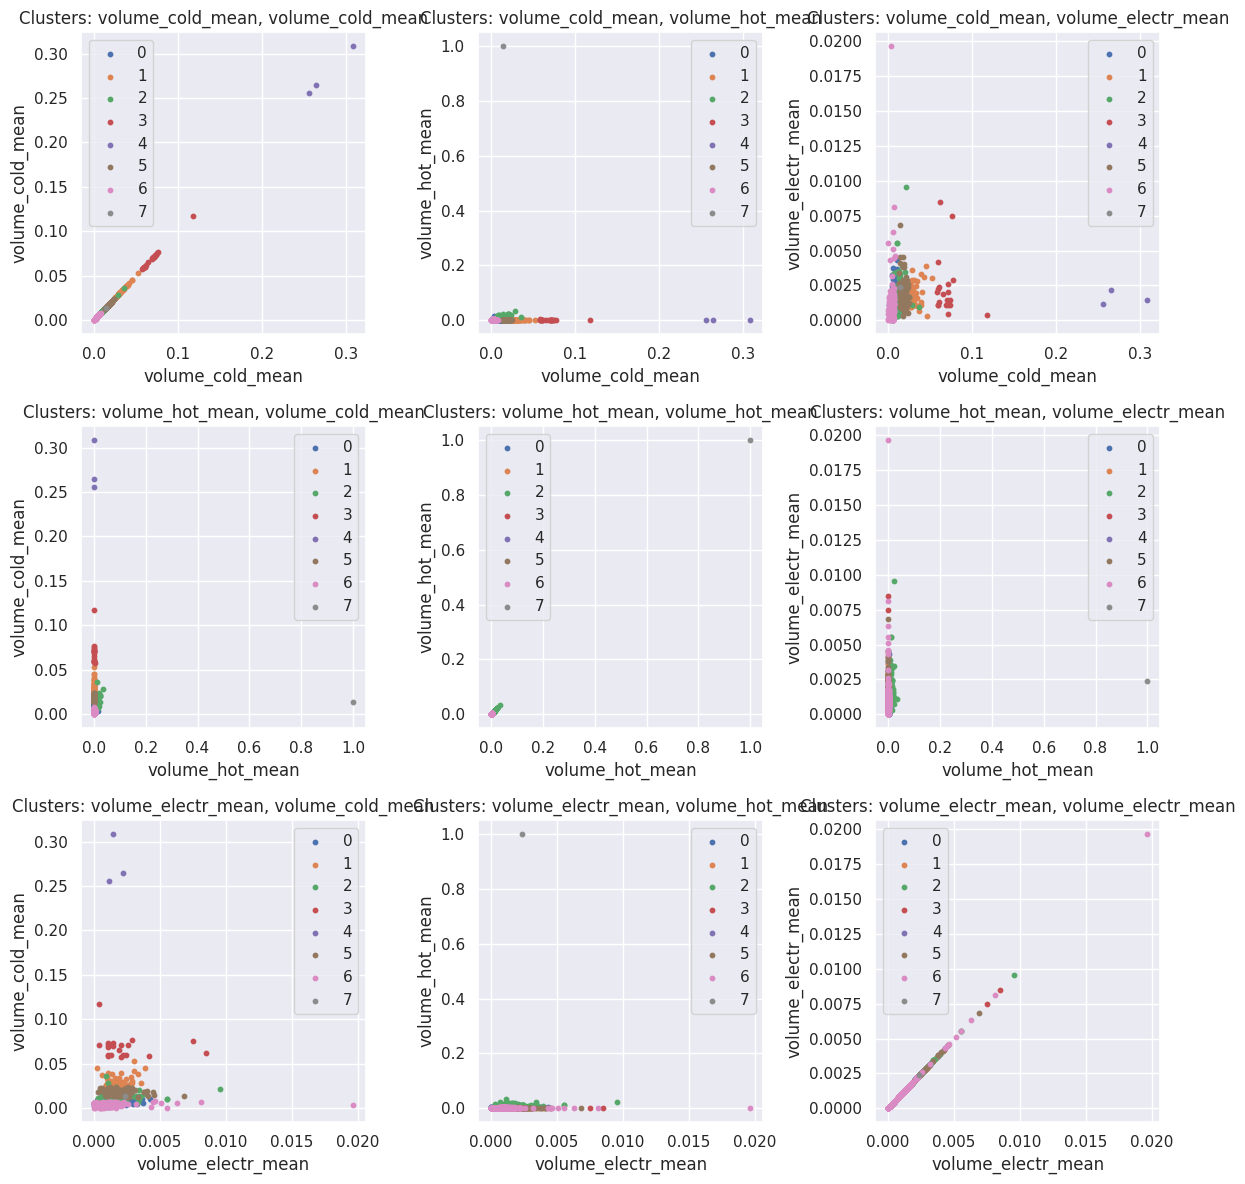

In [51]:
columns_to_consider = ["volume_cold_mean", "volume_hot_mean", "volume_electr_mean"]
X, label, _ = run_ward(columns_to_consider, n_clusters = 8, subset_size = 10000)

columns_to_plot = ["volume_cold_mean", "volume_hot_mean", "volume_electr_mean"]
plot_2d_results(columns_to_consider, columns_to_plot, X, label)

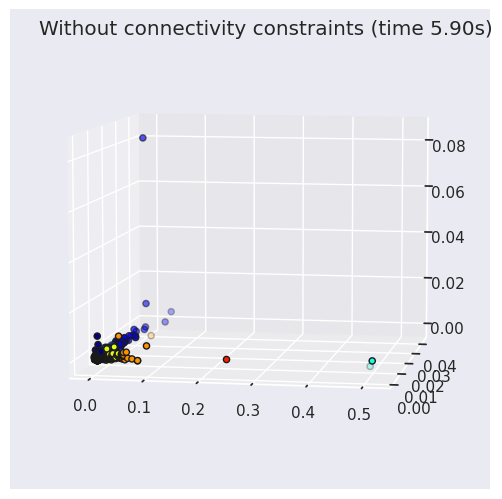

In [47]:
plot_3d_results(columns_to_consider, columns_to_plot, X, label, plot_vertices_number=1000)

In [ ]:
# Experiment 2: 4 clusters

Compute unstructured hierarchical clustering...
Elapsed time: 7.25s
Number of points: 10000


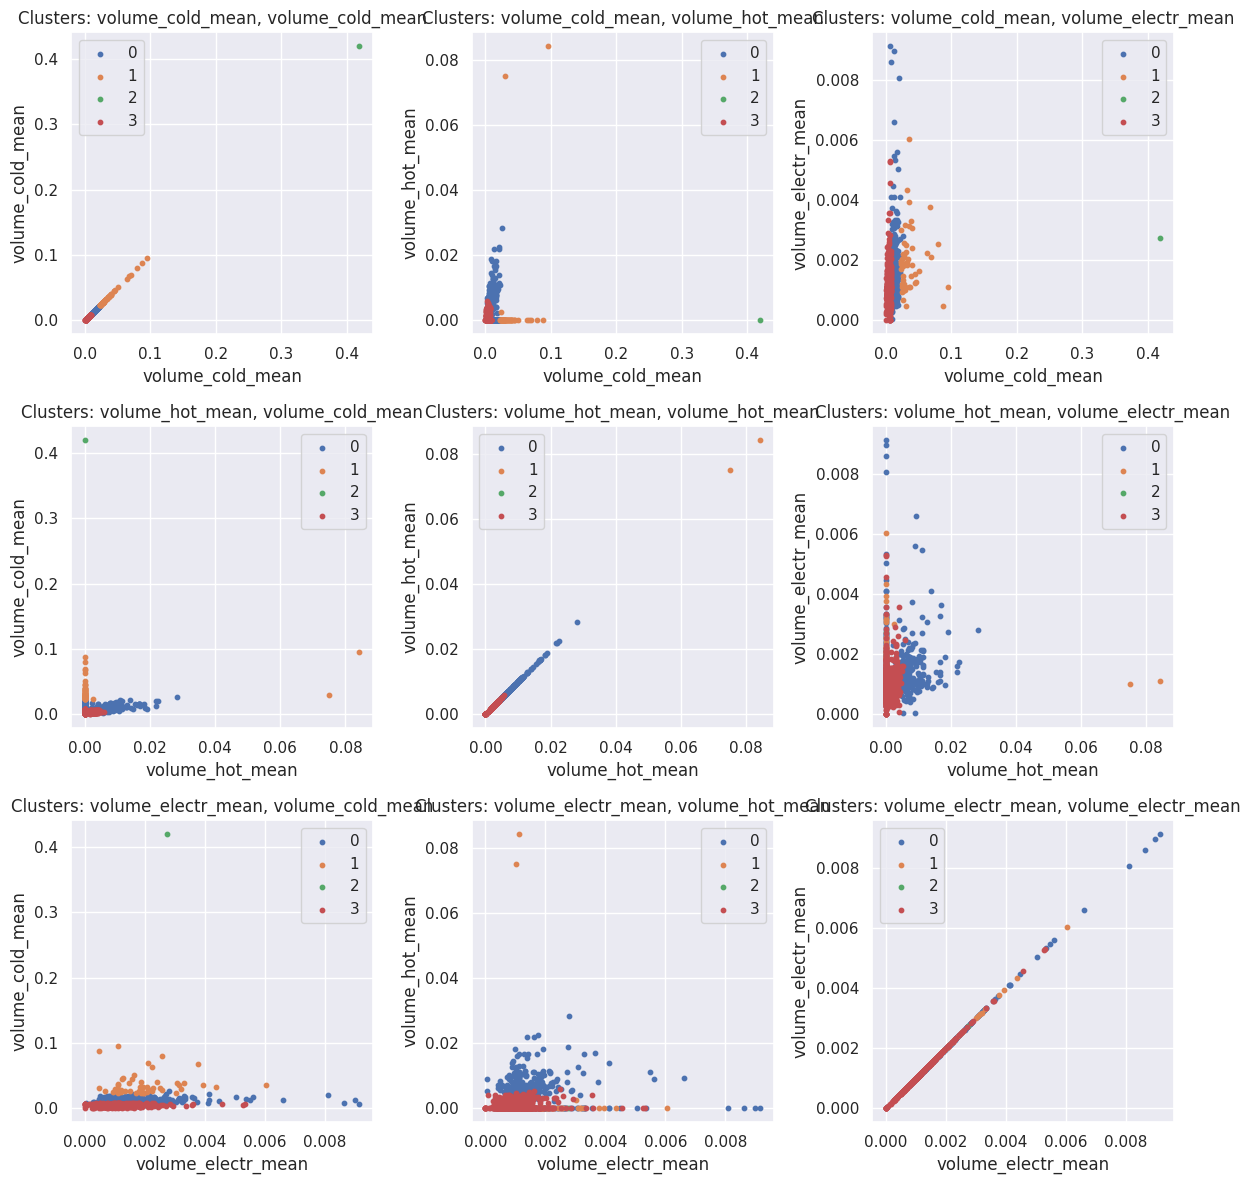

In [53]:
columns_to_consider = ["volume_cold_mean", "volume_hot_mean", "volume_electr_mean"]
X, label, _ = run_ward(columns_to_consider, n_clusters = 4, subset_size = 10000)

columns_to_plot = ["volume_cold_mean", "volume_hot_mean", "volume_electr_mean"]
plot_2d_results(columns_to_consider, columns_to_plot, X, label)

In [64]:
def plot_cluster_value_distribution(columns_to_consider, columns_to_plot, subset_features, labels, plot_vertices_number=1000):
    plot_combinations = [columns_to_consider.index(col) for col in columns_to_plot]
    n_clusters = labels.max() + 1

    fig, axes = plt.subplots(len(plot_combinations), 1, figsize=(6, 12))

    # Subset for plotting (at least 20 points per class, rest random)
    plot_subset_indices = []
    for j in range(n_clusters):
        cluster_indices = np.where(labels == j)[0]
        plot_subset_indices.extend(random.sample(list(cluster_indices), min(len(cluster_indices), 20)))
    plot_subset_indices.extend(random.sample(range(len(subset_features)), min(len(subset_features), plot_vertices_number - 20 * n_clusters)))
    subset_features = subset_features[plot_subset_indices]
    labels = labels[plot_subset_indices]

    for i, x_id in enumerate(plot_combinations):
        ax = axes[i]
        ax.cla()

        for j in range(n_clusters):
            cluster_points = subset_features[labels == j][:, x_id]
            percentile_5 = np.percentile(cluster_points, 5)
            percentile_95 = np.percentile(cluster_points, 95)
            cluster_points = cluster_points[(percentile_5 < cluster_points) & (cluster_points < percentile_95) ]
            ax.hist(cluster_points, bins=10, label=f'Cluster {j}', alpha=0.8)

        ax.set_xlabel(columns_to_consider[x_id])
        ax.set_ylabel("Frequency")
        ax.set_title(f'Value Distribution for {columns_to_consider[x_id]}')
        ax.legend()

    plt.tight_layout()
    plt.show()

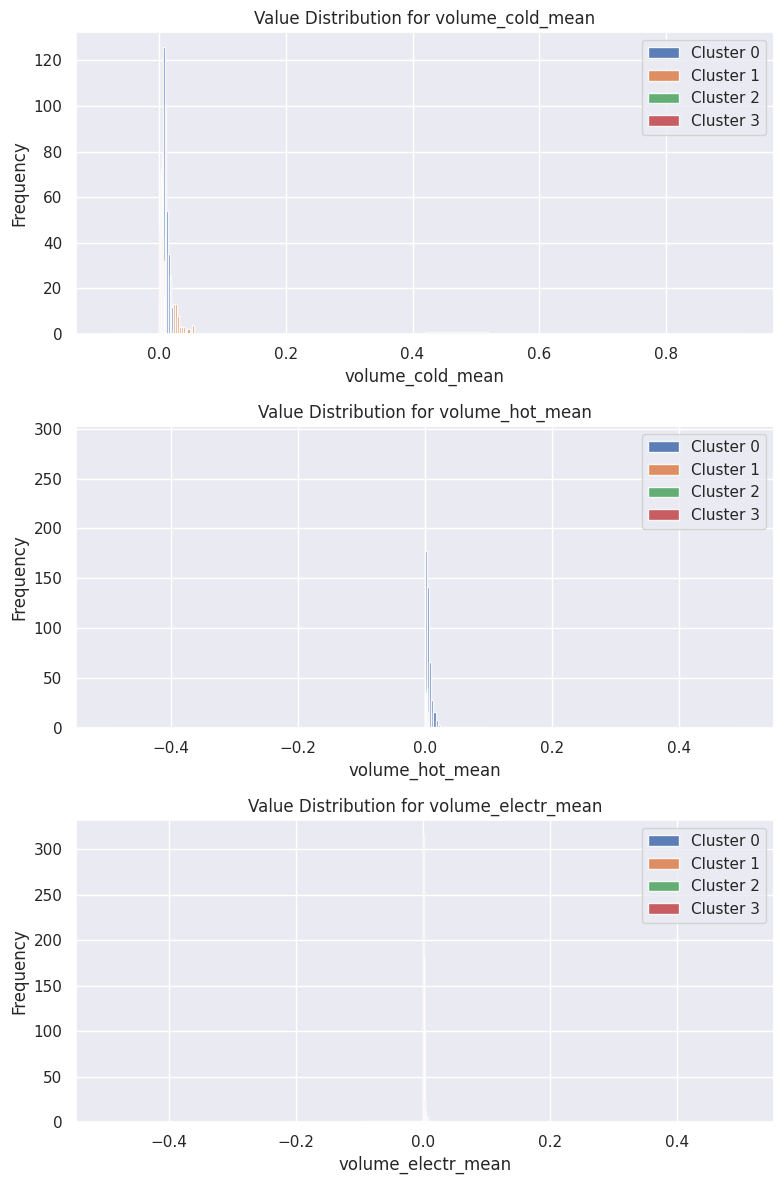

In [69]:
plot_cluster_value_distribution(columns_to_consider, columns_to_plot, X, label)

In [68]:
def plot_cluster_value_distribution(columns_to_consider, columns_to_plot, subset_features, labels, plot_vertices_number=1000):
    plot_combinations = [columns_to_consider.index(col) for col in columns_to_plot]
    n_clusters = labels.max() + 1

    fig, axes = plt.subplots(len(plot_combinations), 1, figsize=(8, 12))

    # Subset for plotting (at least 20 points per class, rest random)
    plot_subset_indices = []
    for j in range(n_clusters):
        cluster_indices = np.where(labels == j)[0]
        plot_subset_indices.extend(random.sample(list(cluster_indices), min(len(cluster_indices), 20)))
    plot_subset_indices.extend(random.sample(range(len(subset_features)), min(len(subset_features), plot_vertices_number - 20 * n_clusters)))
    subset_features = subset_features[plot_subset_indices]
    labels = labels[plot_subset_indices]

    for i, x_id in enumerate(plot_combinations):
        ax = axes[i]

        # Pre-calculate histogram data
        histogram_data = []
        percentiles_5 = []
        percentiles_95 = []
        for j in range(n_clusters):
            cluster_points = subset_features[labels == j][:, x_id]

            # Calculate 5th and 95th percentiles
            percentile_5 = np.percentile(cluster_points, 5)
            percentile_95 = np.percentile(cluster_points, 95)

            # Calculate histogram data
            hist, bin_edges = np.histogram(cluster_points, bins=10)
            histogram_data.append((hist, bin_edges))
            percentiles_5.append(percentile_5)
            percentiles_95.append(percentile_95)

        # Plot histogram bars
        for j in range(n_clusters):
            hist, bin_edges = histogram_data[j]
            width = bin_edges[1] - bin_edges[0]
            ax.bar(bin_edges[:-1] + width/2, hist, width=width, label=f'Cluster {j}', alpha=0.9)

            # Add vertical lines for the percentiles
            #ax.axvline(percentiles_5[j], color='red', linestyle='--', label='5th Percentile')
            #ax.axvline(percentiles_95[j], color='blue', linestyle='--', label='95th Percentile')

        ax.set_xlabel(columns_to_consider[x_id])
        ax.set_ylabel("Frequency")
        ax.set_title(f'Value Distribution for {columns_to_consider[x_id]}')
        ax.legend()

    plt.tight_layout()
    plt.show()